In [1]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os

In [9]:
data = input_data.read_data_sets('data/fashion', one_hot=True,\
    source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')
xTrain = data.train.images.reshape(-1,28,28,1)
yTrain = data.train.labels
xTest = data.test.images.reshape(-1,28,28,1)
yTest = data.test.labels
print(xTrain.shape, yTrain.shape, xTest.shape, yTest.shape)

label_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal',\
    6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle-boot'}

Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1) (55000, 10) (10000, 28, 28, 1) (10000, 10)


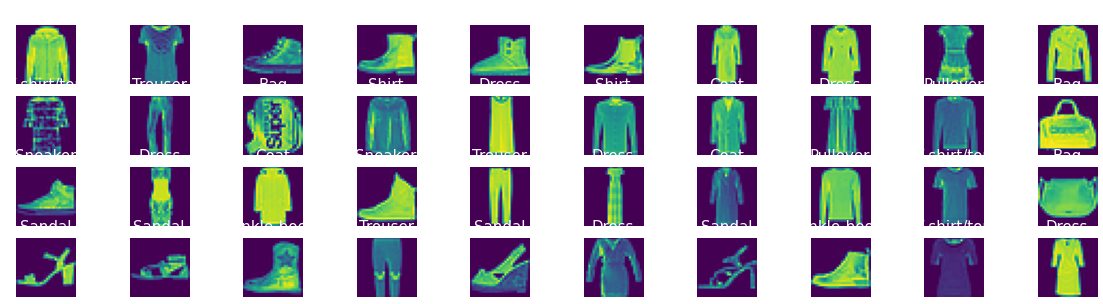

In [15]:
plt.figure(figsize=(20,5))
for i in range(40):
    plt.subplot(4,10,1+i)
    plt.imshow( xTrain[i].reshape(28,28) )
    plt.title( label_dict[np.argmax(yTrain[i,:])], c='white', fontSize=15)
    plt.axis('off')
plt.show()

In [5]:
#training_iters = 3 #10
#learning_rate = 0.001
batch_size = 128
#n_input = 28
#n_classes = 10
x = tf.placeholder("float", [None, 28,28,1])
y = tf.placeholder("float", [None, len(label_dict)])

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()),
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()),
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()),
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('W6', shape=(128,len(label_dict)), initializer=tf.contrib.layers.xavier_initializer()),
} # tf.get_variable(name,shape,initializer)
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

def conv_net(x, weights, biases):
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv3 = maxpool2d(conv3, k=2)
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [6]:
pred = conv_net(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('./board', sess.graph)
    for i in range(10):
        for batch in range(len(xTrain)//batch_size):
            xBatch = xTrain[batch*batch_size:min((batch+1)*batch_size,len(xTrain))]
            yBatch = yTrain[batch*batch_size:min((batch+1)*batch_size,len(yTrain))]    
            opt = sess.run(optimizer, feed_dict={x:xBatch, y:yBatch})
            loss, acc = sess.run([cost, accuracy], feed_dict={x:xBatch, y:yBatch})
        valLoss, valAcc,  = sess.run([cost, accuracy], feed_dict={x:xTest, y:yTest})
        print("Epoch={}, Loss={:.4f}, Acc={:.4f}, valLoss={:.4f}, valAcc={:.4f}".format(\
            i,loss,acc,valLoss,valAcc))
        train_loss.append(loss)
        test_loss.append(valLoss)
        train_accuracy.append(acc)
        test_accuracy.append(valAcc)
    
    tf.train.Saver().save(sess, "model.ckpt")
    summary_writer.close()

Epoch=0, Loss=0.3091, Acc=0.8828, valLoss=0.4009, valAcc=0.8512
Epoch=1, Loss=0.2108, Acc=0.9297, valLoss=0.3370, valAcc=0.8747
Epoch=2, Loss=0.1813, Acc=0.9219, valLoss=0.3125, valAcc=0.8887
Epoch=3, Loss=0.1604, Acc=0.9453, valLoss=0.3071, valAcc=0.8884
Epoch=4, Loss=0.1474, Acc=0.9375, valLoss=0.3019, valAcc=0.8902
Epoch=5, Loss=0.1236, Acc=0.9688, valLoss=0.2947, valAcc=0.8942
Epoch=6, Loss=0.1047, Acc=0.9844, valLoss=0.2838, valAcc=0.9002
Epoch=7, Loss=0.0882, Acc=0.9766, valLoss=0.2833, valAcc=0.9017
Epoch=8, Loss=0.0976, Acc=0.9766, valLoss=0.2864, valAcc=0.9025
Epoch=9, Loss=0.0885, Acc=0.9609, valLoss=0.2896, valAcc=0.9043


In [11]:
with tf.Session() as sess:
    tf.train.Saver().restore(sess, "model.ckpt")
    result = sess.run(pred, feed_dict={x:xTest[:20]})
    predictLabel = np.argmax(result,axis=1)
    trueLabel = np.argmax(yTest,axis=1)
    for i in range(20):
        print(label_dict[predictLabel[i]], label_dict[trueLabel[i]], predictLabel[i]==trueLabel[i])

INFO:tensorflow:Restoring parameters from model.ckpt
Ankle-boot Ankle-boot True
Pullover Pullover True
Trouser Trouser True
Trouser Trouser True
Shirt Shirt True
Trouser Trouser True
Coat Coat True
Shirt Shirt True
Sandal Sandal True
Sneaker Sneaker True
Coat Coat True
Sandal Sandal True
Sandal Sneaker False
Dress Dress True
Coat Coat True
Trouser Trouser True
Pullover Pullover True
Coat Coat True
Bag Bag True
T-shirt/top T-shirt/top True


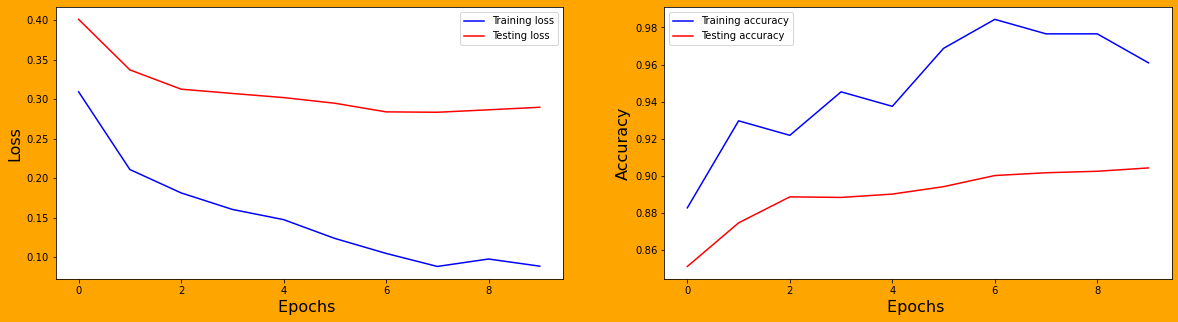

In [24]:
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('orange')

plt.subplot(1,2,1)
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')
plt.legend(labels=['Training loss', 'Testing loss'])
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'b')
plt.plot(test_accuracy, 'r')
plt.legend(labels=['Training accuracy', 'Testing accuracy'])
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.show()

In [25]:
!tensorboard --logdir board

^C
